# Preparation

## Loading packages & Setting variables

In [1]:
import pandas as pd
import numpy as np
import warnings
import gc
import os
import random
import pickle
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset
import lightgbm as lgb
import plotly.express as px
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

warnings.simplefilter("ignore")
pd.options.display.max_columns=1000
torch.autograd.set_detect_anomaly(True)

class CFG:
    # hyper parameters
    EPOCHS = 50
    PRETRAIN_EPOCHS = 100
    THRESHOLD = .5
    BATCH_SIZE = 2**6
    WARM_UP = min(20, EPOCHS//10) # do not stop early
    EARLY_STOPPING_ROUNDS = max(EPOCHS//20, WARM_UP)
    LEARNING_RATE = .01
    SEED = 1
    
    # utils
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    VERBOSE = True # or False
    PREDICT_ALL = False # True or False
    
    SUBMISSION_MODE = False
    CHECKPOINT = False
    RESUME = True
    PRETRAINING_OMIT = True
    TRAINING_OMIT = False
    if SUBMISSION_MODE:
        CHECKPOINT = False
        RESUME = False
        PRETRAINING_OMIT = True
        TRAINING_OMIT = True
        VERBOSE = False
    elif CHECKPOINT:
        RESUME = False
        PRETRAINING_OMIT = False
        TRAINING_OMIT = False
    else:
        RESUME = True
        if TRAINING_OMIT:
            PRETRAINING_OMIT = True
    INPUT = '../input'
    CHECKPOINT_PATH = '../checkpoint/PretrainAsDynamicData/'
    if not os.path.exists(CHECKPOINT_PATH):
        os.mkdir(CHECKPOINT_PATH)

if CFG.SUBMISSION_MODE:
    import jo_wilder_310
    
random.seed(CFG.SEED)
np.random.seed(CFG.SEED)
torch.manual_seed(CFG.SEED)
torch.cuda.manual_seed(CFG.SEED)

lq_dict = {
    "0-4":["q"+str(i) for i in range(1,4)],
    "5-12":["q"+str(i) for i in range(4,14)],
    "13-22":["q"+str(i) for i in range(14,19)]
}
questions = ['q'+str(i) for i in range(1,19)]

%env CUDA_LAUNCH_BLOCKING=1

Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 786 ('font.family:  IPAexGothic')
Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 787 ('figure.figsize: 16.4, 12.3')
Duplicate key in file PosixPath('/opt/conda/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'), line 788 ('figure.dpi: 150')


env: CUDA_LAUNCH_BLOCKING=1


## Functions & Classes

### Data Processing Class

In [2]:
%%time

class DataProcessing():
    def __init__(
        self,
        level_group:str="0-4",
        stride:int=1,
        filter_size:int=10
    ):
        self.level_group=level_group
        self.stride=stride
        self.filter_size=filter_size
    
    def get_labels(self, path=f"{CFG.INPUT}/train_labels.csv"):
        train_labels = pd.read_csv(path, engine='python')
        train_labels[["session_id", "question"]] = train_labels.session_id.str.split("_", expand=True)
        train_labels = train_labels[["session_id", "question", "correct"]]
        train_labels["session_id"] = train_labels["session_id"].astype(int)
        train_labels = train_labels.pivot(index="session_id", columns="question", values="correct").sort_index()
        train_labels = train_labels.reindex(columns=questions)
        return train_labels
    
    def fit_transform(self, path:str=None, df:pd.DataFrame=None):
        return self.transform(path=path, df=df, fit=True)
    
    def transform(self, path:str=None, df:pd.DataFrame=None, fit=False):
        if path:
            self.df = pd.read_csv(path)
            self.df = self.df.query(f"level_group=='{self.level_group}'").reset_index(drop=True)
        if df:
            self.df = df.copy()
            self.df = self.df.query(f"level_group=='{self.level_group}'").reset_index(drop=True)
        df = self.df.copy()
        df = df.drop(["index", "page", "text", "level_group"], axis=1)
        
        df = df.sort_values(["session_id", "elapsed_time"]).reset_index(drop=True)
        df.elapsed_time = [t if t>=0 else 0 for t in df.elapsed_time.diff()]
        df.elapsed_time = df.elapsed_time.shift(-1).fillna(0)
        
        df["distance_room"] = df.room_coor_x.diff()**2 + df.room_coor_y.diff()**2
        df["distance_room"][df.session_id.diff()!=0] = 0
        df["distance_room"] = df["distance_room"].shift(-1).fillna(0)
        df["distance_room"] = df["distance_room"].apply(lambda x: np.sqrt(x))
        df["distance_screen"] = df.screen_coor_x.diff()**2 + df.screen_coor_y.diff()**2
        df["distance_screen"][df.session_id.diff()!=0] = 0
        df["distance_screen"] = df["distance_screen"].shift(-1).fillna(0)
        df["distance_screen"] = df["distance_screen"].apply(lambda x: np.sqrt(x))
        
        df.hover_duration = df.hover_duration.fillna(0)
        df["av"] = df.fullscreen.astype(str)+df.hq.astype(str)+df.music.astype(str)
        df = df.drop([
            "room_coor_x",
            "room_coor_y",
            "screen_coor_x",
            "screen_coor_y",
            "fullscreen",
            "hq",
            "music"
        ], axis=1)
        
        self.continuous_features= [
            'elapsed_time',
            'hover_duration',
            'distance_room',
            'distance_screen'
        ]
        df = self.standardize_continuous(df, self.continuous_features, fit)

        self.categorical_features=[
            'event_name', # first one is the pretraining label
            'name',
            'level',
            'fqid',
            'room_fqid',
            'text_fqid',
            'av'            
        ]
        df = self.label_encoding(df, self.categorical_features, fit)
            
        type_dict = dict(
            session_id='int64',
            elapsed_time='float64',
            event_name='int8',
            name='int8',
            level='int8',
            hover_duration='float64',
            fqid='int16',
            room_fqid='int16',
            text_fqid='int16',
            av='int8',
            distance_room='float64',
            distance_screen='float64'
        )
        df = df[[col for col in type_dict.keys()]].astype(type_dict)
        df = self.make_columns_same(df, fit)
        
        assert df.isnull().sum().sum()==0, ("Data includes NULL.")
        
        x_categorical, x_continuous = self.tensor_processing(df, fit)
        
        session_change_index = df.session_id.diff()!=0
        session_change_index = session_change_index[session_change_index].index.to_list()
        session_change_index += [len(df)]
        translate_table = {k:df.loc[k, ["session_id"]].tolist()[0] for k in session_change_index[:-1]}

        del df, self.df
        gc.collect()
        
        x_categorical, x_continuous, session_index = self.stride_data(
            x_categorical,
            x_continuous,
            session_change_index,
            translate_table
        )
        
        del session_change_index, translate_table
        gc.collect()
        
        assert len(session_index)==x_continuous.shape[0]==x_categorical.shape[0], ("Length Differ Between Outputs.")
        
        return x_categorical, x_continuous, session_index
    
    def standardize_continuous(self, df:pd.DataFrame, columns:list, fit:bool=False):
        if fit:
            ss = StandardScaler()
            df[columns] = ss.fit_transform(df[columns])
            self.scaler = ss
        else:
            ss = self.scaler
            df[columns] = ss.transform(df[columns])
        return df
   
    def label_encoding(self, df:pd.DataFrame, columns:list, fit:bool=False):
        if fit:
            self.encoders = {}
            self.all_pad_tensor = []
            for col in columns:
                if col != "level":
                    df[col] = df[col].fillna("MissingValue")
                    le = LabelEncoder()
                    le.fit(df[col].unique().tolist()+["PAD"])
                    df[col] = le.transform(df[col])
                    self.encoders[col] = le
                    self.all_pad_tensor += [le.classes_.tolist().index("PAD")]
                else:
                    self.all_pad_tensor += [23]
            self.all_pad_tensor = torch.Tensor(self.all_pad_tensor).int()
        else:
            for col in columns:
                if col != "level":
                    df[col] = df[col].fillna("MissingValue")
                    le = self.encoders[col]
                    df[col] = [v if v in le.classes_ else "MissingValue" for v in df[col]]
                    df[col] = le.transform(df[col])
        return df
    
    def make_columns_same(self, df:pd.DataFrame, fit:bool=False):
        if fit:
            self.columns=df.columns
        else:
            df = df[self.columns]
        return df
    
    def tensor_processing(
        self,
        df:pd.DataFrame,
        fit:bool=False,
        num_special_tokens:int=0,
        pretrain_label_continuous:str="elapsed_time"
    ):
        if fit:
            self.num_special_tokens = num_special_tokens
            self.num_continuous = len(self.continuous_features)
            self.categories = [df[col].nunique() for col in self.categorical_features]
            self.categories_offset = torch.Tensor(
                [self.num_special_tokens]+self.categories
            ).int().cumsum(dim=-1)
            self.num_tokens = self.categories_offset[-1]
            self.num_total_tokens = self.num_tokens + self.num_special_tokens
        
        x_categorical = torch.Tensor(df[self.categorical_features].values)
        x_categorical += self.categories_offset[:-1] # avoid duplication between columns
        x_categorical = x_categorical.int()
        
        x_continuous = torch.Tensor(df[self.continuous_features].values)
        
        return x_categorical, x_continuous
    
    def stride_data(
        self,
        categorical:torch.Tensor,
        continuous:torch.Tensor,
        change_index:list,
        translate_table:dict
    ):
        categorical_data = []
        continuous_data = []
        session_index = []
        all_pad_continuous = torch.zeros(continuous.shape[1])
        stride = self.stride
        filter_size = self.filter_size
        
        for i in range(len(change_index)-1):
            begining = change_index[i]
            ending = change_index[i+1]
            for i2 in range(begining, ending-filter_size+1, stride):
                categorical_data.append(categorical[i2:i2+filter_size])
                continuous_data.append(continuous[i2:i2+filter_size])
                session_index.append(translate_table[begining])
            # head    
            categorical_data.append(
                torch.concat(
                    [
                        self.all_pad_tensor.repeat(stride).view(stride, -1),
                        categorical[begining:begining+(filter_size-stride)]
                    ], axis=0
                )
            )
            continuous_data.append(
                torch.concat(
                    [
                        all_pad_continuous.repeat(stride).view(stride, -1),
                        continuous[begining:begining+(filter_size-stride)]
                    ], axis=0
                )
            )
            # tail
            continuous_data.append(
                torch.concat(
                    [
                        continuous[ending-(filter_size-stride):ending],
                        all_pad_continuous.repeat(stride).view(stride, -1)
                    ], axis=0
                )
            )
            categorical_data.append(
                torch.concat(
                    [
                        categorical[ending-(filter_size-stride):ending],
                        self.all_pad_tensor.repeat(stride).view(stride, -1)
                    ], axis=0
                )
            )
            session_index += [translate_table[begining]]*2
            
        categorical = torch.stack(categorical_data)
        continuous = torch.stack(continuous_data)
            
        return categorical, continuous, session_index


CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 35.5 µs


In [3]:
%%time

dp = DataProcessing()
train = dp.fit_transform(f"{CFG.INPUT}/train.csv")
test = dp.transform(f"{CFG.INPUT}/test.csv")
train_labels = dp.get_labels()

CPU times: user 1min 29s, sys: 7.54 s, total: 1min 37s
Wall time: 1min 36s


In [17]:
model = Encoder(dp.num_total_tokens, dp.num_continuous, dp.filter_size)
model(test[0], test[1]).shape

torch.Size([412, 10, 11, 32])

### PretrainModel

In [16]:
class Encoder(nn.Module):
    def __init__(
        self,
        num_total_tokens:int,
        num_continuous:int,
        filter_size:int=10,
        dim:int=32,
        heads:int=8,
        dim_head:int=16,
        attention_dropout:float=.1,
        pretrain_label_continuous:str="elapsed_time",
        continuous_features:list=[
            'elapsed_time',
            'hover_duration',
            'distance_room',
            'distance_screen'
        ],
    ):
        super(Encoder, self).__init__()
        self.num_total_tokens = num_total_tokens
        self.num_continuous = num_continuous
        self.dim = dim
        self.pretrain_label_continuous_idx = continuous_features.index(pretrain_label_continuous)
        
        self.embedding = Embedding(num_total_tokens, num_continuous, filter_size, dim)
        self.column_attention = Attention(dim, heads, dim_head, attention_dropout)
        self.row_attention = Attention(dim, heads, dim_head, attention_dropout)
        
    def forward(
        self,
        x_categorical:torch.Tensor,
        x_continuous:torch.Tensor,
        pretrain_mode:bool=True
    ):
        x = torch.concat(self.embedding(x_categorical.clone(), x_continuous.clone()), dim=2)
        x = self.column_attention(x)
        x = torch.permute(x, (0,2,1,3))
        x = self.row_attention(x)
        x = torch.permute(x, (0,2,1,3))
        
        if pretrain_model:
            label_categorical, label_continuous = self.make_label(x_categorical, x_continuous)
        
        return x
    
    def make_label(self, x_categorical, x_continuous):
        label_categociral = F.one_hot(
            x_categorical[:,:,0].to(torch.int64),
            num_classes=torch.unique(x_categorical[:,:,0]).shape[0]
        ).to(torch.int8)
        label_continuous = x_continuous[:, self.pretrain_label_continuous_idx]
        return label_categorical, label_continuous
        

In [13]:
class Embedding(nn.Module):
    def __init__(
        self,
        num_total_tokens:int,
        num_continuous:int,
        filter_size:int=10,
        dim:int=32
    ):
        super(Embedding, self).__init__()                
        self.dim = dim
        self.embedding_categorical = EmbeddingCategorical(num_total_tokens, dim)
        self.embedding_continuous = EmbeddingContinuous(num_continuous, filter_size, dim)
        
    def forward(self, x_categorical, x_continuous):
        x_categorical = self.embedding_categorical(x_categorical)
        x_continuous = self.embedding_continuous(x_continuous) # batch_size, filter_size, num_features, dim 
        return x_categorical, x_continuous
        
class EmbeddingCategorical(nn.Module):
    def __init__(
        self,
        num_total_tokens:int,
        dim:int=32,
    ):
        super(EmbeddingCategorical, self).__init__()
        self.dim=dim
        self.num_total_tokens=num_total_tokens
        self.embedding=nn.Embedding(self.num_total_tokens, self.dim)
        
    def forward(self, x):
        x = self.embedding(x)
        return x
        
class EmbeddingContinuous(nn.Module):
    def __init__(
        self,
        num_continuous:int,
        filter_size:int=10,
        dim:int=32
    ):
        super(EmbeddingContinuous, self).__init__()
        self.num_continuous=num_continuous
        self.dim=dim
        self.filter_size=filter_size
        self.projections = nn.ModuleList(
            [
                ProjectingContinuous(dim=dim)
                for _ in range(self.num_continuous*self.filter_size)
            ]
        )
        
    def forward(self, x):
        x_enc = torch.zeros(*x.shape, self.dim) # batch_size, filter_size, num_features, dim 
        for s in range(self.filter_size):
            for i in range(self.num_continuous):
                x_enc[:,s,i,:] = self.projections[s*self.num_continuous+i](x[:,s,i])
        return x_enc
        
class ProjectingContinuous(nn.Module):
    def __init__(
        self,
        intermediate_unit=100,
        dim:int=32,
    ):
        super(ProjectingContinuous, self).__init__()
        self.linear1 = nn.Linear(1, intermediate_unit)
        self.linear2 = nn.Linear(intermediate_unit, dim)
        
    def forward(self, x):
        if len(x.shape)==1:
            x = x.view(x.size(0), -1)
        
        x = F.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

In [7]:
class Attention(nn.Module):
    def __init__(
        self,
        dim:int=32,
        heads:int=8,
        dim_head:int=16,
        dropout:float=.1
    ):
        super(Attention, self).__init__()
        self.dim=dim
        self.heads=heads
        self.dim_head=dim_head
        self.key = nn.Linear(dim, dim_head*heads, bias=False)
        self.query = nn.Linear(dim, dim_head*heads, bias=False)
        self.value = nn.Linear(dim, dim_head*heads, bias=False)
        self.out = nn.Linear(dim_head*heads, dim)
        
    def forward(self, x):
        # x.shape -> batch_size, filter_size, num_features, dim=32
        batch_size, filter_size, num_features, dim = x.shape
        
        # k.shape -> batch_size, filter_size, num_features, dim_head*heads=128
        key, query, value = self.key(x), self.query(x), self.value(x)

        # k.shape -> batch_size, heads, filter_size, num_features, dim_head
        reshaping = lambda t:torch.permute(t, (0,1,3,2)).reshape(
            batch_size, self.heads, filter_size, num_features, self.dim_head
        )
        key, query, value = map(reshaping, [key, query, value])
        
        attention = torch.einsum('bhsid, bhsjd -> bhsij', (query, key))
        attention /= self.dim_head**0.5
        attention = attention.softmax(dim=-1)
        attention = torch.einsum('bhsij, bhsjd -> bhsid', (attention, value))

        # attention.shape -> batch_size, filter_size, num_features, dim_head*heads=128
        attention = attention.view(batch_size, filter_size, num_features, self.dim_head*self.heads)

        # attention.shape -> batch_size, filter_size, num_features, dim=32
        attention = self.out(attention)

        return attention

### Dataloader Creating Functions

In [3]:
def create_loader_train(X, X_mask, y, level_group=None, train_rate=.9, predict_all=False):
    if level_group:
        X = X.query(f'level_group=="{level_group}"')
        X = X.reset_index().drop("level_group", axis=1).set_index("session_id")
        X_mask = X_mask.query(f'level_group=="{level_group}"')
        X_mask = X_mask.reset_index().drop("level_group", axis=1).set_index("session_id")
    
    if predict_all:
        pass
    else:
        y = y[lq_dict[level_group]]
        
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=1-train_rate, random_state=CFG.SEED)
    res = msss.split(X.values, y.values)
    for train_index, val_index in res:
        train_index = train_index.tolist()
        val_index = val_index.tolist()

    train_loader = DataLoader(
        TensorDataset(
            torch.Tensor(X.iloc[train_index, :].values),
            torch.Tensor(X_mask.iloc[train_index, :].values).type(torch.int),
            torch.Tensor(y.iloc[train_index, :].values),
        ),
        batch_size=CFG.BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )

    val_loader = DataLoader(
        TensorDataset(
            torch.Tensor(X.iloc[val_index, :].values),
            torch.Tensor(X_mask.iloc[val_index, :].values).type(torch.int),
            torch.Tensor(y.iloc[val_index, :].values),
        ),
        batch_size=CFG.BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )

    del train_index
    gc.collect()

    return train_loader, val_loader

def create_loader_test(X, X_mask, level_group=None):
    if CFG.SUBMISSION_MODE:
        pass
    elif level_group:
        X = X.query(f'level_group=="{level_group}"')
        X = X.reset_index().drop("level_group", axis=1).set_index("session_id")
        X_mask = X_mask.query(f'level_group=="{level_group}"')
        X_mask = X_mask.reset_index().drop("level_group", axis=1).set_index("session_id")

    test_loader = DataLoader(
        TensorDataset(
            torch.Tensor(X.values),
            torch.Tensor(X_mask.values).type(torch.int),
        ),
        batch_size=1000, shuffle=False
    )
    
    return test_loader

### MultiOutputsModel

In [4]:
class MultiOutputsModel(nn.Module):
    def __init__(self, num_features=10, num_outputs=10,
                 units=[64, 128, 64, 64, 32],
                 units_sub=[16, 32, 16, 8, 1],
                 pretrained_model=None,
                 dim=None
                ):
        super(MultiOutputsModel, self).__init__()
        self.name = "MultiOutputsModel"
        self.num_features = num_features
        self.dim = dim
        self.num_outputs = num_outputs
        
        if pretrained_model:
            self.embedding = pretrained_model.embedding
            self.saint = pretrained_model.saint
            
            self.each_dim_models =  nn.ModuleList([
                EachSAINTDimModel(
                    num_features=num_features,
                    num_outputs=num_outputs,
                    units=units,
                    units_sub=units_sub,
                    dim=dim
                )
                for _ in range(dim)
            ])
            
            self.last_output_layers = nn.ModuleList([
                SigmoidLayer(dim, 1) for _ in range(num_outputs)
            ])
        
    def register_pretrained_model(self, pretrained_model):
        for param in pretrained_model.parameters():
            param.requires_grad = False
        self.__init__(
            num_features=pretrained_model.embedding.num_features,
            dim=pretrained_model.dim,
            num_outputs=self.num_outputs,
            pretrained_model=pretrained_model,
        )
        
    def forward(self, x, x_mask):
        x = self.embedding(x.clone(), x_mask.clone())
        x = self.saint(x)
        #x = torch.mean(x, dim=1) #x[:,0,:]

        dim_outputs = []
        for i_dim, l in enumerate(self.each_dim_models):
            dim_outputs.append(l(x[:,:,i_dim].clone()))
        x = torch.stack(dim_outputs)
        x = torch.transpose(x, 0, 1)
        
        last_outputs = []
        for i_output, l in enumerate(self.last_output_layers):
            last_outputs.append(l(x[:,:,i_output].clone()))
            
        x = torch.concat(last_outputs, dim=1)
        return x

class EachSAINTDimModel(nn.Module):
    def __init__(self, num_features=10, num_outputs=10,
                 units=[128, 256, 128, 64, 32],
                 units_sub=[64, 16, 32, 16, 1],
                 dim=None
                ):
        super(EachSAINTDimModel, self).__init__()
        self.num_features = num_features
        self.dim = dim
        self.units = [self.num_features] + units
        self.units_sub = [self.units[-1]] + units_sub
        
        self.l1_bn = nn.BatchNorm1d(self.units[0])
        self.l1 = nn.Linear(self.units[0], self.units[1])
        nn.init.xavier_normal_(self.l1.weight)
        
        self.ls = nn.ModuleList([
            LeakyReLULayer(self.units[i+1], self.units[i+2])
            if i%2 == 1 else ResidualBlock(self.units[i+1], self.units[i+2])
            for i in range(len(self.units)-2)
        ])
        self.num_outputs = num_outputs
        
        self.subs = nn.ModuleList([
            MultiOutputsModelSub(self.units[-1])
            for _ in range(num_outputs)
        ])
        
    def forward(self, x):
        x = F.leaky_relu(self.l1(self.l1_bn(x)))
        x = F.dropout(x, .1, training=self.training)
        for l in self.ls:
            x = l(x)

        res = []
        for sub in self.subs:
            res.append(sub(x.clone()))            
        x = torch.concat(res, dim=1)
        
        return x
    
class MultiOutputsModelSub(nn.Module):
    def __init__(self, num_inputs, units_sub=[64, 16, 32, 16, 1]):
        super(MultiOutputsModelSub, self).__init__()
        self.geglu_layer = GeGLULayer(num_inputs, units_sub[0])
        self.units_sub = units_sub
        self.ls_sub =  nn.ModuleList([
            LeakyReLULayer(self.units_sub[i], self.units_sub[i+1])
            if i < len(self.units_sub)-1 else
            SigmoidLayer(self.units_sub[i], self.units_sub[i+1])
            for i in range(len(self.units_sub)-1)
        ])
                
    def forward(self, x):
        x = self.geglu_layer(x)
        for i, l in enumerate(self.ls_sub):
            if i+1 < len(self.units_sub)-1:
                x = l(x)
            else:
                x = F.dropout(x, .2, training=self.training)
                x = l(x)
        return x

class LeakyReLULayer(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LeakyReLULayer, self).__init__()
        self.bn = nn.BatchNorm1d(num_inputs)
        self.linear = nn.Linear(num_inputs, num_outputs)
                
    def forward(self, x):
        x = self.linear(self.bn(x))
        x = F.leaky_relu(x)
        return x

class SigmoidLayer(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(SigmoidLayer, self).__init__()
        self.bn = nn.BatchNorm1d(num_inputs)
        self.linear = nn.Linear(num_inputs, num_outputs)
                
    def forward(self, x):
        x = self.linear(self.bn(x))
        x = F.sigmoid(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(ResidualBlock, self).__init__()
        self.layer1 = LeakyReLULayer(num_inputs, 32)
        self.layer2 = LeakyReLULayer(32, 16)
        self.layer3 = LeakyReLULayer(16, num_inputs)
        self.geglu = GeGLULayer(num_inputs, num_outputs)
                
    def forward(self, x):
        x_mlp = self.layer1(x.clone())
        x_mlp = self.layer2(x_mlp)
        x += self.layer3(x_mlp)
        x = self.geglu(x)
        return x
    
class GeGLULayer(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(GeGLULayer, self).__init__()
        self.bn = nn.BatchNorm1d(num_inputs)
        self.linear = nn.Linear(num_inputs, num_outputs*2)
        self.geglu = GEGLU()
                
    def forward(self, x):
        x = self.linear(self.bn(x))
        x = self.geglu(x)
        return x

### SAINT

In [5]:
class MLP(nn.Module):
    def __init__(self, three_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(three_dim[0], three_dim[1]),
            nn.ReLU(),
            nn.Linear(three_dim[1], three_dim[2])
        )
        
    def forward(self, x):
        if len(x.shape)==1:
            x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

class EmbeddingLayer(nn.Module):
    def __init__(self, num_features, dim=32):
        super(EmbeddingLayer, self).__init__()
        self.dim = dim
        self.num_features = num_features
        self.MLPs = nn.ModuleList([MLP([1, 100, dim]) for _ in range(num_features)])
        mask_offset = F.pad(
            torch.Tensor(num_features).fill_(2).type(torch.int8),
            (1,0),
            value=0
        ).cumsum(dim=-1)[:-1].to(CFG.DEVICE)
        self.register_buffer('mask_offset', mask_offset)
        self.embedding_mask = nn.Embedding(num_features*2, dim)
        
    def forward(self, x, x_mask):
        x_enc = torch.empty(*x.shape, self.dim).to(CFG.DEVICE)
        for i in range(self.num_features):
            x_enc[:,i,:] = self.MLPs[i](x[:,i])
        x_enc[x_mask==0] = self.embedding_mask(x_mask+self.mask_offset.type_as(x_mask))[x_mask==0]
        return x_enc
    
class SAINT(nn.Module):
    def __init__(self, num_features, dim=32, heads=8, dim_head=16, attention_dropout=.1, ff_dropout=.1):
        super(SAINT, self).__init__()
        self.msa = Attention(dim, heads, dim_head, attention_dropout)
        self.ff1 = FeedForward(dim, dropout=ff_dropout)
        self.misa = Attention(dim*num_features, heads, 64, attention_dropout)
        self.ff2 = FeedForward(dim*num_features, dropout=ff_dropout)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim*num_features)
        self.norm4 = nn.LayerNorm(dim*num_features)
        
    def forward(self, x):
        shape = x.shape
        
        x = self.norm1(x)
        x += self.msa(x.clone())
        
        x = self.norm2(x)
        x += self.ff1(x.clone())
        x = x.view(1, shape[0], -1)
        
        x = self.norm3(x)
        x += self.misa(x.clone())
        
        x = self.norm4(x)
        x += self.ff2(x.clone())
        x = x.view(*shape)
        
        return x

class Attention(nn.Module):
    def __init__(self, dim=32, heads=8, dim_head=16, dropout=0.1):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.reshaping = lambda x, shape: torch.permute(x, (0,2,1)).reshape(shape[0], heads, shape[1], -1)
        self.to_qkv = nn.Linear(dim, inner_dim*3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        q, k, v = self.to_qkv(x).chunk(3, dim =-1)
        shape = q.shape
        q, k, v = self.reshaping(q, shape), self.reshaping(k, shape), self.reshaping(v, shape)
        sim = torch.einsum('b h i d, b h j d -> b h i j', (q,k)) * self.scale
        attention = sim.softmax(dim=-1)
        out = torch.einsum('b h i j, b h j d -> b h i d', attention, v)
        out_shape = out.shape
        out = out.view(out_shape[0], out_shape[2], -1)
        out = self.to_out(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, dim=32, mult=4, dropout=.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(dim, dim*mult*2)
        self.linear2 = nn.Linear(dim*mult, dim)
        self.dropout = dropout
        self.geglu = GEGLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.geglu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.linear2(x)
        return x
    
class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x*F.gelu(gates)
    
class Constrastive(nn.Module):
    def __init__(self, num_features, dim=32, temperature=0.7):
        super(Constrastive, self).__init__()
        units = [
            dim*num_features,
            6*dim*num_features//5,
            dim*num_features//2
        ]
        self.projection_head_true = MLP(units)
        self.projection_head_false = MLP(units)
        self.reshaping = lambda x: (x / x.norm(dim=-1, keepdim=True)).flatten(1,2)
        self.temperature = temperature
        
    def forward(self, x_true, x_false):
        x_true, x_false = self.reshaping(x_true), self.reshaping(x_false)
        x_true = F.normalize(self.projection_head_true(x_true), dim=-1).flatten(1)
        x_false = F.normalize(self.projection_head_false(x_false), dim=-1).flatten(1)  
        logits = x_true @ x_false.t() / self.temperature
        logits_ =  x_false @ x_true.t() / self.temperature
        targets = torch.arange(logits.size(0)).to(CFG.DEVICE)
        loss = F.cross_entropy(logits, targets, reduction="mean")
        loss_ = F.cross_entropy(logits_, targets, reduction="mean")
        loss = (loss + loss_) / 2
        return loss
    
class Denoising(nn.Module):
    def __init__(self, num_features, dim=32):
        super(Denoising, self).__init__()
        self.num_features = num_features
        self.MLPs = nn.ModuleList([
            MLP([dim, dim*5, 1])
            for i in range(num_features)
        ])
        
    def forward(self, x, x_original):
        x = [
            self.MLPs[i](x[:,i,:])
            for i in range(1, self.num_features) # except for CLS
        ]
        x = torch.cat(x,dim=1)
        loss = F.mse_loss(x, x_original[:,1:], reduction="mean")
        return loss

### Pretraining Class

In [6]:
class PretrainingSAINT(nn.Module):
    def __init__(self, num_features, dim=32):
        super(PretrainingSAINT, self).__init__()
        self.dim = dim
        self.embedding = EmbeddingLayer(num_features, dim)
        self.saint = SAINT(num_features, dim)
        self.contrastive = Constrastive(num_features, dim)
        self.denoising = Denoising(num_features, dim)
    
    def cutmix(self, x, m=.1):
        x = x.clone()
        x_shuffle = x[torch.randperm(x.shape[0]),:]
        random_choice = torch.from_numpy(np.random.choice(2,(x.shape),p=[m,1-m]))
        x[random_choice==0] = x_shuffle[random_choice==0]
        return x

    def mixup(self, x_enc, alpha=.3):
        index = torch.randperm(x_enc.shape[0])
        x_enc = alpha*x_enc + (1-alpha)*x_enc[index, :]
        return x_enc
    
    def forward(self, x, x_mask):
        x_true = self.embedding(x.clone(), x_mask.clone())
        x_true = self.saint(x_true)
        
        x_false = self.cutmix(x.clone())
        x_false = self.embedding(x_false, x_mask.clone())
        x_false = self.mixup(x_false)
        x_false = self.saint(x_false)
        
        contrastive_loss = self.contrastive(x_true.clone(), x_false.clone())
        denoising_loss = self.denoising(x_false.clone(), x.clone())
        
        return contrastive_loss, denoising_loss

In [39]:
np.random.choice(4,(4,4),p=[.25,.25,.25, .25])

array([[2, 0, 3, 0],
       [2, 1, 2, 0],
       [0, 3, 3, 1],
       [2, 3, 3, 0]])

### Pretraining Function

In [7]:
def pretraining(train_loader, level_group, epochs=CFG.EPOCHS, lambda1=.5, lambda2=10, omit=CFG.PRETRAINING_OMIT):
    num_features = train_loader.dataset.tensors[0].shape[1]
    model = PretrainingSAINT(num_features).to(CFG.DEVICE)
    checkpoint_path = f"{CFG.CHECKPOINT_PATH}/pretrain_params_{level_group}.pth"
    
    if omit:
        model.load_state_dict(torch.load(checkpoint_path))
    else:
        optimizer = torch.optim.AdamW(model.parameters(),lr=0.0001)
        losses = [10**10]
        model.train()

        print("Pretraining is starting...") 
        for epoch in tqdm(range(epochs)):
            loss_sum = 0.0
            contrastive_loss_sum = 0.0
            denoising_loss_sum = 0.0
            for i, (X, X_mask, _) in enumerate(train_loader):
                X, X_mask = X.to(CFG.DEVICE), X_mask.to(CFG.DEVICE)
                contrastive_loss, denoising_loss = model(X, X_mask)
                loss = lambda1 * contrastive_loss + lambda2 * denoising_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                contrastive_loss_sum += (lambda1 * contrastive_loss).item()
                denoising_loss_sum += (lambda2 * denoising_loss).item()
                loss_sum += loss.item()

            epoch_loss = loss_sum/i
            if epoch_loss < min(losses):
                best_epoch = epoch
                torch.save(model.state_dict(), checkpoint_path)
            losses.append(epoch_loss)

            print(
                f"Epoch {epoch+1}/{epochs}: loss {epoch_loss: .4f} (contrastive_loss {contrastive_loss_sum/i: .4f}, denoising_loss {denoising_loss_sum/i: .4f})"
            )

        model.load_state_dict(torch.load(checkpoint_path))
        print(f"Pretraining has finished.\nBest Epoch is {best_epoch} with loss {min(losses)} !")
    
    return model

### Other Functions

In [8]:
def calc_weight(data_loader):
    count1 = torch.sum(data_loader.dataset.tensors[2], dim=0)
    count_all = data_loader.dataset.tensors[2].shape[0]
    count0 = count_all - count1
    weight = count0 / count1
    
    del count1, count_all, count0
    gc.collect()
    
    return weight

def calc_matrix(x):
    x = torch.where((x > CFG.THRESHOLD), 1, -1)
    x_t = x.T
    length = x_t.shape[0]
    res = []

    for i in range(length):
        res.append(x *  x.T[i].unsqueeze(-1))
    res = torch.concat(res, dim=1)
    res = res.view(-1, length, length)
    res = torch.where(res==-1, 0.0, 1.0)
    res = torch.mean(res, axis=0).to(CFG.DEVICE)
        
    return res

def explore_threshold(model, val_loader):
    preds, true_values = [], []
    for i, (x, x_mask, t) in enumerate(val_loader):
        x, x_mask, t = x.to(CFG.DEVICE), x_mask.to(CFG.DEVICE), t.to(CFG.DEVICE)
        y = model(x, x_mask).view(-1)
        preds += y
        true_values += t

    preds = torch.stack(preds).view(-1).detach().cpu().numpy()
    true_values = torch.stack(true_values).view(-1).detach().cpu().numpy()
    px.box(x=true_values, y=preds, points="all").show()

    f1s = []
    for th in range(0, 101, 1):
        f1 = f1_score(true_values, (preds > (th/100)).astype(int), average="macro")
        f1s.append(f1)
    f1s = pd.DataFrame({"threshold":[i/100 for i in range(0, 101, 1)], "f1":f1s}).set_index("threshold")
    best_threshold = f1s[f1s.f1.apply(lambda x: x//.01)==f1s.f1.apply(lambda x: x//.01).max()].index.max()
    px.line(f1s, title=f"Best Threshold is {best_threshold}.").show()

    return best_threshold

### Training Function

In [21]:
def training(train_loader, val_loader, model_class, pretrained_model, omit=CFG.TRAINING_OMIT):
    num_features = train_loader.dataset.tensors[0].shape[1]
    num_outputs = val_loader.dataset.tensors[2].shape[1]
    level_group = '0-4' if num_outputs == 3 else '5-12' if num_outputs == 10 else '13-22' if num_outputs == 5 else None
    model = model_class(num_features, num_outputs)
    model.register_pretrained_model(pretrained_model)
    model = model.to(CFG.DEVICE)
    checkpoint_path = f"{CFG.CHECKPOINT_PATH}/{model.name}_bestmodel{'_'+level_group if level_group else ''}{'_all' if CFG.PREDICT_ALL else ''}.pth"
    
    if omit:
        checkpoint_path = f"{CFG.CHECKPOINT_PATH}/{model.name}_bestmodel{'_'+level_group if level_group else ''}{'_all' if CFG.PREDICT_ALL else ''}.pth"
        model.load_state_dict(torch.load(checkpoint_path))
        try:
            with open(f"{CFG.CHECKPOINT_PATH}/{model.name}_thresholds{'_all' if CFG.PREDICT_ALL else ''}.pickle", "rb") as f:
                best_thresholds = pickle.load(f)[level_group]
        except Exception as e:
            print(e)
            best_thresholds = None
        return model, best_thresholds
    else:
        print("Training is starting...") 
        
        weight_ratio = calc_weight(train_loader).to(CFG.DEVICE)
        early_stopping_count = 0
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=.005)
        loss_trains, loss_vals, f1_trains, f1_vals = [], [], [], []
        loss_func = nn.BCELoss(reduction='none')

        for epoch in range(CFG.EPOCHS):
            #"""
            #train
            #"""
            model.train()
            loss_train = 0
            preds, true_values = [], []
            for i, (x, x_mask, t) in enumerate(train_loader):
                x, x_mask, t = x.to(CFG.DEVICE), x_mask.to(CFG.DEVICE), t.to(CFG.DEVICE)
                y = model(x, x_mask)
                preds += y
                true_values += t
                
                weight = (lambda w: torch.where(w==0, 1, w))(t*weight_ratio)
                loss = torch.mean(loss_func(y, t)*weight) / num_outputs
                loss_train += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            scheduler.step()
            loss_train /= i
            loss_trains.append(loss_train)
            preds = torch.stack(preds).view(-1)
            true_values = torch.stack(true_values).view(-1).detach().cpu().numpy()
            f1_train = f1_score(true_values, (preds > CFG.THRESHOLD).int().detach().cpu().numpy(), average="macro")
            f1_trains.append(f1_train)

            #"""
            #validation
            #"""
            model.eval()
            loss_val = 0
            preds, true_values = [], []
            for i, (x, x_mask, t) in enumerate(val_loader):
                x, x_mask, t = x.to(CFG.DEVICE), x_mask.to(CFG.DEVICE), t.to(CFG.DEVICE)
                y = model(x, x_mask)
                preds += y
                true_values += t

                weight = (lambda w: torch.where(w==0, 1, w))(t*weight_ratio)
                try:
                    loss = torch.mean(loss_func(y, t)*weight) / num_outputs
                except Exception as e:
                    print(y)
                    return (x, x_mask, y,t,weight, loss_func, model), None
                loss_val += loss.item()

            loss_val /= i
            loss_vals.append(loss_val)
            preds = torch.stack(preds).view(-1)
            true_values = torch.stack(true_values).view(-1).detach().cpu().numpy()
            f1_val = f1_score(true_values, (preds > CFG.THRESHOLD).int().detach().cpu().numpy(), average="macro")
            f1_vals.append(f1_val)

            print(f"Epoch {epoch+1}/{CFG.EPOCHS}: loss_train {loss_train:.4f}, loss_val {loss_val:.4f}, f1_train {f1_train:.4f} f1_val - {f1_val:.4f}")

            #"""
            #early stopping
            #"""
            if epoch+1 < CFG.WARM_UP: # warm up: do not stop early
                best_score_before = None
                continue
            elif epoch+1 == CFG.WARM_UP:
                best_score_before = min(loss_vals[CFG.WARM_UP-1:])
            else:
                best_score_before = min(loss_vals[CFG.WARM_UP-1:-1])

            if (min(loss_vals[CFG.WARM_UP-1:]) == loss_val) and (best_score_before != loss_val):
                early_stopping_count = 0
                torch.save(model.state_dict(), checkpoint_path)
            else:
                early_stopping_count += 1

            if early_stopping_count == CFG.EARLY_STOPPING_ROUNDS:
                best_epoch = loss_vals.index(min(loss_vals[CFG.WARM_UP-1:]))
                early_stopping_message =\
                f"Best Epoch: {best_epoch+1}"\
                + f", TrainLoss: {loss_trains[best_epoch]:.4f}" + f", ValLoss: {loss_vals[best_epoch]:.4f}"\
                + f", TrainF1: {f1_trains[best_epoch]:.4f}" + f", ValF1: {f1_vals[best_epoch]:.4f}"
                print("\n!!!Early Stopping !!!")
                print(early_stopping_message)
                try:
                    model.load_state_dict(torch.load(checkpoint_path))
                except Exception as e:
                    print(e)
                break
            else:
                best_epoch = epoch + 1

        torch.save(model.state_dict(), checkpoint_path)

        #"""
        #checking train result
        #"""
        result = pd.DataFrame(
            {
                "value": loss_trains + loss_vals + f1_trains + f1_vals,
                "metric": ["loss"] * (len(loss_trains)+len(loss_vals)) + ["f1_score"] * (len(loss_trains)+len(loss_vals)),
                "epoch": ([i+1 for i in range(len(loss_trains))] + [i+1 for i in range(len(loss_vals))])*2,
                "train/val": (["train" for _ in range(len(loss_trains))] + ["val" for _ in range(len(loss_vals))])*2
            }
        )
        px.line(result.query("metric=='loss'"), x="epoch", y="value",
                color="train/val", height=250, title="loss").show()
        px.line(result.query("metric=='f1_score'"), x="epoch", y="value",
                color="train/val", height=250, title="f1_score").show()

        #"""
        #exploring best threshold
        #"""
        preds, true_values = [], []
        for i, (x, x_mask, t) in enumerate(val_loader):
            x, x_mask, t = x.to(CFG.DEVICE), x_mask.to(CFG.DEVICE), t.to(CFG.DEVICE)
            y = model(x, x_mask).view(-1)
            preds += y
            true_values += t

        preds = torch.stack(preds).view(-1).detach().cpu().numpy()
        true_values = torch.stack(true_values).view(-1).detach().cpu().numpy()
        px.box(x=true_values, y=preds, points="all").show()

        f1s = []
        for th in range(0, 101, 1):
            f1 = f1_score(true_values, (preds > (th/100)).astype(int), average="macro")
            f1s.append(f1)
        f1s = pd.DataFrame({"threshold":[i/100 for i in range(0, 101, 1)], "f1":f1s}).set_index("threshold")
        best_threshold = f1s[f1s.f1.apply(lambda x: x//.01)==f1s.f1.apply(lambda x: x//.01).max()].index.max()
        px.line(f1s, title=f"Best Threshold is {best_threshold}.").show()

        #"""
        #fine tuning with validation data
        #"""
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE*.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20*.5, eta_min=.005)

        loss_trains, f1_trains = [], []
        loss_func = nn.BCELoss(reduction='none')
        model.train()

        epochs = max(int(best_epoch*.1), 10)
        for epoch in range(epochs):
            loss_train = 0
            preds, true_values = [], []
            for i, (x, x_mask, t) in enumerate(val_loader):
                x, x_mask, t = x.to(CFG.DEVICE), x_mask.to(CFG.DEVICE), t.to(CFG.DEVICE)
                y = model(x, x_mask)
                preds += y
                true_values += t

                weight = (lambda w: torch.where(w==0, 1, w))(t*weight_ratio)
                loss = torch.mean(loss_func(y, t)*weight) / num_outputs
                loss_train += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            scheduler.step()
            loss_train /= i
            loss_trains.append(loss_train)
            preds = torch.stack(preds).view(-1)
            true_values = torch.stack(true_values).view(-1).detach().cpu().numpy()
            f1_train = f1_score(true_values, (preds > best_threshold).int().detach().cpu().numpy(), average="macro")
            f1_trains.append(f1_train)

            print(f"Epoch {epoch+1}: loss_train {loss_train:.4f}, f1_train {f1_train:.4f}")

            if epoch == 0:
                best_score_before = loss_train
                if f1_train != 0:
                    torch.save(model.state_dict(), checkpoint_path)                  
            else:
                best_score_before = min(loss_trains)

            if (min(loss_trains) == loss_train) and (best_score_before != loss_train):
                if f1_train != 0:
                    torch.save(model.state_dict(), checkpoint_path)                  

        model.load_state_dict(torch.load(checkpoint_path))

        #"""
        #checking train result
        #"""
        result = pd.DataFrame(
            {
                "value": loss_trains + f1_trains,
                "metric": ["loss"] * len(loss_trains) + ["f1_score"] * len(loss_trains),
                "epoch": [i+1 for i in range(len(loss_trains))]*2,
            }
        )
        px.line(result.query("metric=='loss'"), x="epoch", y="value",
                height=250, title="FineTuning: loss").show()
        px.line(result.query("metric=='f1_score'"), x="epoch", y="value",
                height=250, title="FineTuning: f1_score").show()

    return model, best_threshold

### Predicting Function

In [10]:
def predict(test, model, level_group=None, threshold=None, question=None):
    
    if CFG.SUBMISSION_MODE:
        test_idx = test[0].index.unique()
        if question:
            cols = [question]
        else:
            if level_group and model.num_outputs != 18:
                cols = lq_dict[level_group]
            else:
                cols = questions
    elif level_group:
        #test = test.query(f"level_group=='{level_group}'")
        test_idx = [i[0] for i in test[0].index.unique()]
        if threshold is None:
            threshold = CFG.THRESHOLD
        
        if question:
            cols = [question]
        else:
            if model.num_outputs == 18:
                cols = questions
            else:
                cols = lq_dict[level_group]
    else:
        test_idx = test[0].index.unique()
        cols = questions
        if threshold is None:
            threshold = CFG.THRESHOLD
    
    test_loader = create_loader_test(test[0], test[1], level_group)
    preds = []
    model.eval()

    for x, x_mask in test_loader:
        y = model(x.to(CFG.DEVICE), x_mask.to(CFG.DEVICE))
        preds += y
    preds = torch.stack(preds)
    
    submission = pd.DataFrame(
        (preds > threshold).int().detach().cpu().numpy(),
        columns = cols,
    )
    
    submission = submission[cols]
    submission["session_id"] = test_idx
    submission["session_id"] = submission["session_id"].astype(str)
    submission = pd.melt(submission, id_vars="session_id", var_name="question", value_name="correct")
    submission["session_id"] += "_" + submission.question
    submission = submission[["session_id", "correct"]]
    
    del preds, test_idx
    gc.collect()
    
    return submission

### LightGBM for feature elimination

In [11]:
def lgb_training(X, y, params=None, train_rate=.9):
    
    lgb_models = {}
    lgb_preds = {}
    lgb_scores = {}
    fi_df = []
    
    if params is None:
        params = dict(
            objective='binary',
            metric='binary_logloss',
            verbosity=1,
            early_stopping_round=100,
            random_state=CFG.SEED,
            is_unbalance=True,
            num_iterations=2000,
            num_leaves=500,
            lambda_l1=.2,
            lambda_l2=.2,
            bagging_freq=10,
            bagging_seed=CFG.SEED,
            force_col_wise=True
        )
    
    for level_group in lq_dict.keys():
        for q in lq_dict[level_group]:
            X_train, X_val, y_train, y_val = tts(
                X[level_group][0],
                y[q],
                train_size=train_rate,
                random_state=CFG.SEED,
                stratify=y[q]
            )
            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_val = lgb.Dataset(X_val, y_val)

            del X_train, y_train
            gc.collect()

            lgb_model = lgb.train(
                params=params,
                train_set=lgb_train,
                num_boost_round=1000,
                valid_sets=(lgb_train, lgb_val),
                callbacks=None,
                verbose_eval=100
            )

            lgb_models[q] = lgb_model
            lgb_preds[q] = lgb_model.predict(X_val)
            lgb_scores[q] = f1_score(y_val,
                                     [int(p > CFG.THRESHOLD) for p in lgb_preds[q]],
                                     average="macro")

            fi_df.append(
                pd.DataFrame(
                    lgb_model.feature_importance(importance_type="gain"),
                    index=X[level_group][0].columns,
                    columns=[q]
                )
            )

    fi_df = pd.concat(fi_df, axis=1)
    
    feature_elimination_dict = {}
    for level_group in lq_dict.keys():
        fe_cols = fi_df[lq_dict[level_group]].mean(axis=1).sort_values(ascending=False)
        fe_cols = fe_cols.iloc[:30].index.tolist()
        feature_elimination_dict[level_group] = fe_cols
    
    return lgb_models, lgb_preds, lgb_scores, fi_df, feature_elimination_dict

# Execution

## Preparing Objects

In [12]:
%%time

if CFG.SUBMISSION_MODE:
    with open(f"{CFG.CHECKPOINT_PATH}/dp.pickle", "rb") as f:
        dp = pickle.load(f)

    models = {}    
    for level_group in lq_dict.keys():
        num_features = dp.num_features
        pretrained_model = PretrainingSAINT(num_features).to(CFG.DEVICE)
        model = MultiOutputsModel(num_features, 18 if CFG.PREDICT_ALL else len(lq_dict[level_group]))
        model.register_pretrained_model(pretrained_model)
        checkpoint_path = f"{CFG.CHECKPOINT_PATH}/{model.name}_bestmodel{'_'+level_group if level_group else ''}{'_all' if CFG.PREDICT_ALL else ''}.pth"
        model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
        models[level_group] = model
        
    with open(f"{CFG.CHECKPOINT_PATH}/{model.name}_thresholds{'_all' if CFG.PREDICT_ALL else ''}.pickle", "rb") as f:
        thresholds = pickle.load(f)
        
else:
    if CFG.RESUME:
        with open(f"{CFG.CHECKPOINT_PATH}/dp.pickle", "rb") as f:
            dp = pickle.load(f)
        
        with open(f"{CFG.CHECKPOINT_PATH}/train.pickle", "rb") as f:
            train = pickle.load(f)
        
        test = dp.transform(f"{CFG.INPUT}/test.csv")
        
        with open(f"{CFG.CHECKPOINT_PATH}/cooccurence_rate.pickle", "rb") as f:
            cooccurence_rate = pickle.load(f)
        
        train_labels = pd.read_csv(f"{CFG.INPUT}/train_labels.csv", engine='python')
        train_labels[["session_id", "question"]] = train_labels.session_id.str.split("_", expand=True)
        train_labels = train_labels[["session_id", "question", "correct"]]
        train_labels["session_id"] = train_labels["session_id"].astype(int)
        train_labels = train_labels.pivot(index="session_id", columns="question", values="correct").sort_index()
        train_labels = train_labels.reindex(columns=questions)
    else:
        dp = DataProcessing()

        train = dp.fit_transform(f"{CFG.INPUT}/train.csv")
        test = dp.transform(f"{CFG.INPUT}/test.csv")

        if CFG.CHECKPOINT:
            with open(f"{CFG.CHECKPOINT_PATH}/dp.pickle", "wb") as f:
                pickle.dump(dp, f)
            with open(f"{CFG.CHECKPOINT_PATH}/train.pickle", "wb") as f:
                pickle.dump(train, f)

        del dp
        gc.collect()

        train_labels = pd.read_csv(f"{CFG.INPUT}/train_labels.csv", engine='python')
        train_labels[["session_id", "question"]] = train_labels.session_id.str.split("_", expand=True)
        train_labels = train_labels[["session_id", "question", "correct"]]
        train_labels["session_id"] = train_labels["session_id"].astype(int)
        train_labels = train_labels.pivot(index="session_id", columns="question", values="correct").sort_index()
        train_labels = train_labels.reindex(columns=questions)

        check = train_labels.copy()
        res = {}
        for session_id, row in check[questions].iterrows():
            tmp = []
            for i1, q1 in enumerate(row):
                for i2, q2 in enumerate(row):
                    tmp.append((questions[i1], questions[i2], int(q1==q2)))
            tmp = pd.DataFrame(tmp)
            tmp = pd.pivot(data=tmp, index=0, columns=1, values=2)
            res[session_id] = np.array(tmp.reindex(index=questions, columns=questions))

        cooccurence_rate = np.mean(list(res.values()), axis=0)
        cooccurence_rate = pd.DataFrame(data=cooccurence_rate, columns=questions)
        cooccurence_rate.index = questions

        if CFG.CHECKPOINT:
            with open(f"{CFG.CHECKPOINT_PATH}/cooccurence_rate.pickle", "wb") as f:
                pickle.dump(cooccurence_rate, f)

elapsed_time processing has finished!
coor processing has finished!
text processing has finished!
name processing has finished!
event_name processing has finished!
others processing has finished!
final processing has finished!

CPU times: user 3.89 s, sys: 248 ms, total: 4.14 s
Wall time: 4.13 s


## Deep Learning


level_group 0-4 model...
'0-4'


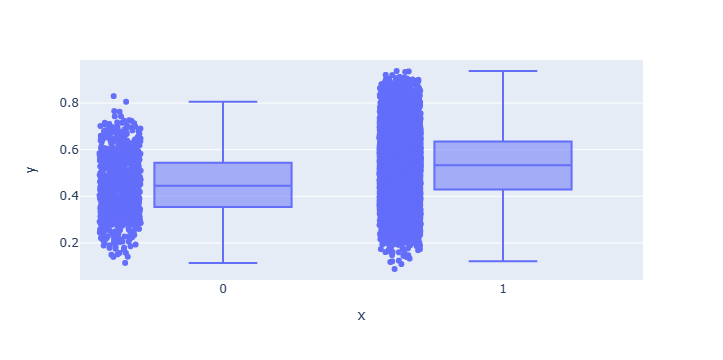

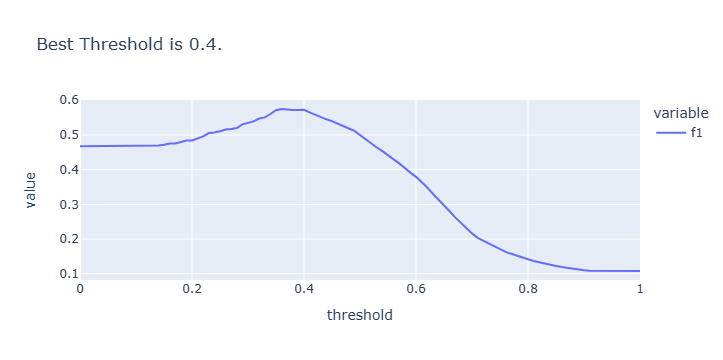

,session_id,correct
0,20090109393214576_q1,1
1,20090312143683264_q1,0
2,20090312331414616_q1,1
3,20090109393214576_q2,1
4,20090312143683264_q2,1
5,20090312331414616_q2,1
6,20090109393214576_q3,1
7,20090312143683264_q3,1
8,20090312331414616_q3,1



level_group 5-12 model...
'5-12'


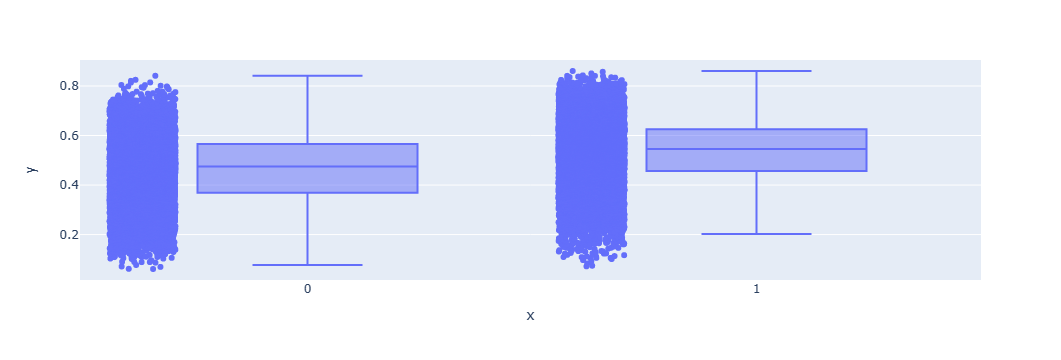

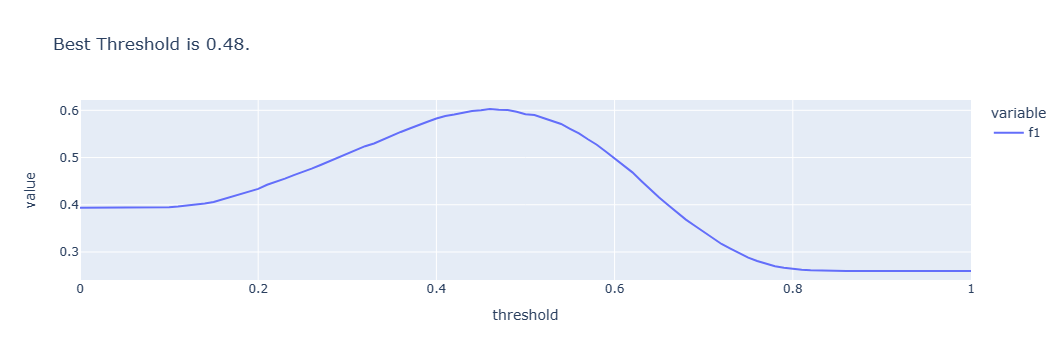

,session_id,correct
0,20090109393214576_q4,0
1,20090312143683264_q4,0
2,20090312331414616_q4,1
3,20090109393214576_q5,0
4,20090312143683264_q5,0
5,20090312331414616_q5,1
6,20090109393214576_q6,0
7,20090312143683264_q6,0
8,20090312331414616_q6,1
9,20090109393214576_q7,0



level_group 13-22 model...


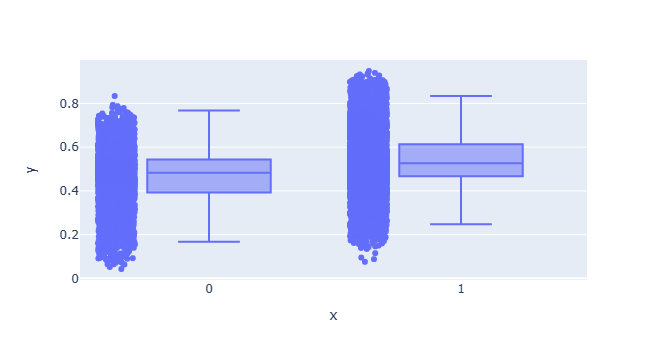

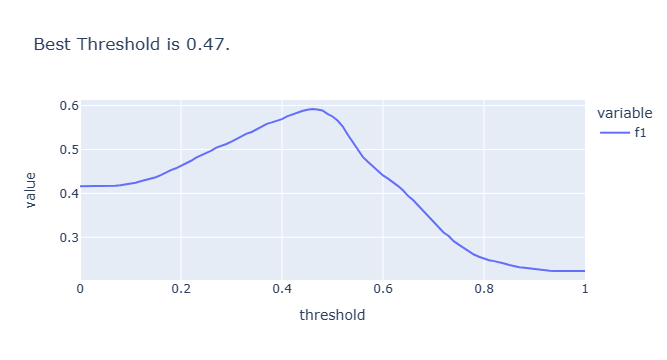

,session_id,correct
0,20090109393214576_q14,0
1,20090312143683264_q14,0
2,20090312331414616_q14,1
3,20090109393214576_q15,0
4,20090312143683264_q15,0
5,20090312331414616_q15,1
6,20090109393214576_q16,1
7,20090312143683264_q16,1
8,20090312331414616_q16,1
9,20090109393214576_q17,0


CPU times: user 3min 58s, sys: 36.1 s, total: 4min 34s
Wall time: 4min 40s


In [22]:
%%time

if CFG.SUBMISSION_MODE:    
    env = jo_wilder_310.make_env()
    iter_test = env.iter_test()

    storage = []
    for x, sample in iter_test:
        level_group = x.level_group.values[0]
        if level_group == "0-4":
            storage.append(x)
            x = dp.transform(data=x, decided_level_group=level_group)
        elif level_group == "5-12":
            storage.append(x)
            x = pd.concat(storage, axis=0, ignore_index=True)
            x.level_group = level_group
            x = dp.transform(data=x, decided_level_group=level_group)
        else: # "13-22"
            x = pd.concat(storage + [x], axis=0, ignore_index=True)
            x.level_group = level_group
            x = dp.transform(data=x, decided_level_group=level_group)
            storage = []
        
        submission = predict(x, models[level_group], level_group, thresholds[level_group])
        submission = submission.set_index("session_id").reindex(sample.session_id).reset_index()
        env.predict(submission)                       

else:
    thresholds = {}
    for level_group in lq_dict.keys():
        print(f"\nlevel_group {level_group} model...")
        
        # create data loader
        train_loader, val_loader = create_loader_train(
                            train[level_group][0],
                            train[level_group][1],
                            train_labels,
                            level_group,
                            predict_all=CFG.PREDICT_ALL
                        )
        # pretraining
        pretrained_model = pretraining(
            train_loader,
            level_group,
            epochs=CFG.PRETRAIN_EPOCHS,
            omit=CFG.PRETRAINING_OMIT
        )
            
        # training
        model, best_threshold = training(
            train_loader,
            val_loader,
            MultiOutputsModel,
            pretrained_model,
            omit=True#CFG.TRAINING_OMIT
        )
        
        best_threshold = explore_threshold(model, val_loader)
            
        # predicting
        submission = predict(test[level_group], model, level_group, best_threshold)
        display(submission)
        submission.to_csv("submission.csv", index=False)
        
        thresholds[level_group] = best_threshold
        
        torch.cuda.empty_cache()
    
    thresholds_path = f"{CFG.CHECKPOINT_PATH}/{model.name}_thresholds{'_all' if CFG.PREDICT_ALL else ''}.pickle"
    with open(thresholds_path, "wb") as f:
        pickle.dump(thresholds, f)